<a href="https://colab.research.google.com/github/parthasarathydNU/gen-ai-coursework/blob/main/vae-intro/ConvolutionalVariationalAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Reference](https://www.tensorflow.org/tutorials/generative/cvae#define_the_loss_function_and_the_optimizer)

# Convolutional Variational Auto Encoder

In this notebook we explore how to build a Variational Auto Encoder and the various concepts around it.

Unlike a traditional auto encoder that maps the input vector into a latent space, the Variational Auto encoder tries to map the data into inputs for a known probability distribution such as mean and variance. This approach produces a continuous, structured latent space that is useful for image generation.

# Setup

In [2]:
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-9wjdgiuk
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-9wjdgiuk
  Resolved https://github.com/tensorflow/docs to commit 940d94cb568bcdd4e82402eff3403ddcf5f874f2
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.5.3.31743-py3-none-any.whl size=182531 sha256=9bf5bf522bf59d39ac445e12925b6388cc3cf917fadc704812998bd8a0110924
  Stored in directory: /tmp/pip-ephem-wheel-cache-4t9t_mh8/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [3]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

# Load the MNIST dataset

Each MNIST image is a vector of 784 integers, each between 0 - 255 and represents the intensity of a pixel.

In [4]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


# Converting data to a bernoulli distribution

In [5]:
def preprocess_images(images):
  """
  In this function we convert the images to a binary format
  Based on a bernoulli distribution
  We first normalize the immage values between 0 and 1
  Then we binarize it to 0 or 1 based on the threshold value
  """
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

In [6]:
train_images.shape

(60000, 28, 28)

In [7]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 170,
        253, 253, 253, 253, 253, 225, 172, 253, 242, 195,  64,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  49, 238, 253, 253, 253, 253,
        253, 253, 253, 253, 251,  93,  82,  82,  56,  39,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  18, 219, 253, 253, 253, 253,
        253, 198, 182, 247, 241,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  80, 156, 107, 253, 253,
        205,  11,   0,  43, 154,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  14,   1, 154, 253,
         90,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 139, 253,
        190,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  11, 190,
        253,  70,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  35,
        241, 225, 160, 108,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         81, 240, 253, 253, 119,  25,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  45, 186, 253, 253, 150,  27,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  16,  93, 252, 253, 187,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 249, 253, 249,  64,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  46, 130, 183, 253, 253, 207,   2,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  39,
        148, 229, 253, 253, 253, 250, 182,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  24, 114, 221,
        253, 253, 253, 253, 201,  78,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  23,  66, 213, 253, 253,
        253, 253, 198,  81,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  18, 171, 219, 253, 253, 253, 253,
        195,  80,   9,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  55, 172, 226, 253, 253, 253, 253, 244, 133,
         11,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 136, 253, 25

In [8]:
train_images[0][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=uint8)

# Converting to binary distribution

In [9]:
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [10]:
train_images.shape

(60000, 28, 28, 1)

In [11]:
train_images[0].shape

(28, 28, 1)

In [12]:
train_images[0][0]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

# Reshaping the images and converting the Bernoulli Distribution : WHY ?



The function `preprocess_images(images)` is designed to prepare image data for use in a machine learning model, specifically by processing the images into a format that is suitable for a neural network. The function does two main operations on the input images: reshaping and binarizing. Here's a breakdown of each step:

1. **Reshaping the Images:**
   - **`images.reshape((images.shape[0], 28, 28, 1))`:** This line changes the shape of the input array `images`. The reason for this reshaping involves several factors:
     - **Original Shape:** MNIST dataset images are typically stored in a flat array of 784 elements per image (since 28x28 pixels = 784). For use in most convolutional neural networks (CNNs), it is necessary for the input data to be in the form of matrices (or more precisely, tensors) that represent the 2D structure of the images.
     - **Target Shape:**
       - **`images.shape[0]`** is the number of images in the batch. This part remains dynamic, accommodating whatever batch size is being processed.
       - **`(28, 28)`** converts each flat 784 element vector into a 28x28 matrix which represents the original 2D structure of the images.
       - **`1`** at the end of the shape tuple adds a single channel to the images, making it compatible with the expected input format for CNNs which typically expect images to have dimensions [batch_size, height, width, channels]. For grayscale images like those in the MNIST dataset, the channel dimension is 1.
     - **Normalization:** The division by 255 is a normalization step, converting pixel values from the range [0, 255] to [0, 1]. This step is important for neural network models as it helps in faster convergence during training by maintaining numerical stability.

2. **Binarizing the Images:**
   - **`np.where(images > .5, 1.0, 0.0).astype('float32')`:** After the images are reshaped and normalized, this line binarizes the image data:
     - **Thresholding at 0.5:** This uses a threshold of 0.5 on the normalized pixel values. If a pixel's value is greater than 0.5, it is set to 1.0; otherwise, it is set to 0.0. This step is effectively turning the grayscale images into black and white images, where each pixel is either fully "on" (1.0) or fully "off" (0.0). The choice of 0.5 as a threshold works well in practice for images where pixel values are normalized between 0 and 1.
     - **Type Conversion:** `.astype('float32')` converts the data type of the numpy array to `float32`, which is a common data type used in neural networks due to a good balance between precision and memory requirements.

Overall, the `preprocess_images` function not only adjusts the format and shape of the image data to make it suitable for processing with convolutional neural networks but also simplifies the data representation by converting it to binary. This can lead to more efficient learning when dealing with binary or nearly-binary images such as handwritten digits, which often don't require the full range of grayscale to be accurately represented and recognized.

## Why do we convert it to a bernoulli distribution ?

Variational Autoencoders (VAEs) are a type of generative model that often use specific assumptions about the distribution of input data to simplify the training process and improve the model's performance. When working with image data like the MNIST dataset, these assumptions can play a crucial role. Here's why pixels are converted to a Bernoulli distribution and statistically binarized:

1. **Binarization of Images:**
   - **Data Simplification:** MNIST images, which are grayscale, contain pixel values ranging from 0 to 255. Binarizing these values (i.e., converting them to 0s and 1s) simplifies the model by reducing the complexity of the input space. Instead of modeling 256 possible intensities for each pixel, the model only needs to consider two states: on or off (pixel is white or black).
   - **Match to Output Activation:** VAEs often use a sigmoid activation function in the output layer, which constrains the output values between 0 and 1. Binarizing the inputs to also be 0 or 1 makes it easier for the model to learn the appropriate mappings since the output directly corresponds to the probability of a pixel being on (1) or off (0).

2. **Modeling Pixels with Bernoulli Distribution:**
   - **Probabilistic Interpretation:** The Bernoulli distribution is a simple discrete distribution, which has two possible outcomes: 0 or 1. This matches the binarized nature of the input data. By modeling each pixel as a Bernoulli distributed variable, the model learns to output the probability that a given pixel should be 1 (pixel on) based on the latent space representation.
   - **Training Objective:** In VAEs, the objective includes a reconstruction loss that measures how well the output of the decoder matches the original input. For binarized data, this is typically measured using the binary cross-entropy between the input images and the reconstructed probabilities. The cross-entropy is a natural choice for loss when dealing with probabilities output from a Bernoulli distribution, effectively encouraging the model to adjust its parameters to minimize the difference between the predicted probabilities and the actual binary values of the input pixels.

3. **Statistical Efficiency and Stability:**
   - **Reduction of Variability:** By converting pixel values to a binary format, you reduce the intra-class variability among the pixels, which can lead to more stable and efficient learning. This is because the model no longer needs to account for varying degrees of intensity within the same class of objects (digits in the case of MNIST).
   - **Robustness:** Models trained on binary data tend to be less sensitive to small variations and noise in pixel values, which can be beneficial, especially in simpler models or when computational resources are limited.

In summary, converting pixel values from grayscale to a binary format and modeling these binary values with a Bernoulli distribution simplifies the VAE's learning process, aligns with the nature of the output layer's activation function, and is suitable for the kind of reconstruction loss used (binary cross-entropy). This approach makes training more straightforward and often more effective for generating or reconstructing binary images.

# Setting Parameters

In [13]:
test_images.shape

(10000, 28, 28, 1)

In [14]:
train_images.shape

(60000, 28, 28, 1)

In [15]:
train_size = 60000
batch_size = 32
test_size = 10000

# Use tf.data to batch and shuffle the data

In [16]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

# Defining the encoder and decoder networks with tf.keras

In this VAE we use two small Convolutional Neural Networks for the encoder and decoder networks. These models are referred to as inference/recognition and generation models respectively.

Let `x` and `z` denote the observation and latent variable respectively in the following descriptions.

## Encoder Network

This defines the approximate posterior distribution `q(z|x)`, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation `z`. In this example, simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian. Output log-variance instead of the variance directly for numerical stability.

> Let's break down the concepts mentioned:

### Diagonal Gaussian
In a VAE, the encoder network models the distribution of latent variables as a Gaussian (normal) distribution. The term **"diagonal Gaussian"** refers to the type of covariance matrix used in this Gaussian distribution. A diagonal covariance matrix means that all off-diagonal entries are zero, implying that there are no correlations between different latent variables. Each latent variable has its variance, but these variances don't interact. This simplification makes it easier to compute and less parameter-intensive than a full covariance matrix.

### Mean and Log-Variance Outputs
The encoder network does two key things:
1. **Outputs the Mean:** This is the mean of the Gaussian distribution of the latent variables. It represents the central point around which the latent variable values are distributed, essentially capturing the "average" state of the latent factors for the given input.
2. **Outputs the Log-Variance:** Instead of outputting the variance directly, the encoder outputs the logarithm of the variance. This step is crucial for numerical stability:
   - **Avoid Negative Variance:** Variance must be non-negative, but if the network were to output variance directly, there could be computational issues or optimization difficulties that might lead to negative values, which are not valid. By using the log-variance, the network ensures that the variance is always positive, as the exponential of any real number (which is the inverse operation to logarithm) is positive.
   - **Easier Optimization:** Variance values can span several orders of magnitude (very small to very large). Working in the log space normalizes this scale, potentially leading to smoother and more stable optimization landscapes.

### Why Log-Variance and Not Variance
Outputting the log-variance instead of the variance directly has advantages in terms of numerical stability and computational efficiency:
- **Numerical Stability:** Calculating the variance directly can lead to numerical issues, such as floating-point underflow or overflow, especially when the variance is extremely low (close to zero) or high. Using the logarithm mitigates these risks.
- **Ease of Optimization:** In optimization, especially with gradient descent methods, dealing with parameters that can vary over several orders of magnitude (as variances can) is challenging. Using the logarithm transforms the variance into a scale that's more manageable for the optimizer.

In summary, in a VAE, the encoder network approximates the posterior distribution of the latent variables given the input data. By outputting parameters (mean and log-variance) for a diagonal Gaussian distribution, the encoder simplifies the representation of the input data into a latent space where each dimension is independent and normally distributed. This structured approach allows the VAE not only to efficiently encode variations in the data but also to handle the intricacies of probabilistic generative modeling.

## Decoder Network

This defines the conditional distribution of the observation `p(x|z)`, which takes a latent sample `z` as an input and outputs the parameters for a conditional distribution of the observation. Model the latent distribution priod `p(z)` as a unit Gaussian.

>  My understandign was that the decoder network was supposed to take in a distribution and output back an image. But here I see that it outputs the parameters for a distribution, isn't that the job of the encoder ? 🤔

🤖 💬 Your understanding of the roles of the encoder and decoder in a Variational Autoencoder (VAE) is on the right track, but there's a bit more nuance to how these components interact and what they output, particularly in the case of the decoder.

### Encoder vs. Decoder Roles

- **Encoder Network:** The encoder network takes in the original data (like images) and transforms it into a latent space. As you noted, it outputs parameters for a probability distribution—typically the mean and log-variance of a Gaussian distribution. These parameters define how we think about the latent variables given the input data, thus approximating the posterior distribution of the latent variables.

- **Decoder Network:** The decoder, on the other hand, aims to reconstruct the original input data from the latent space. It takes a sample \( z \) from the latent space—drawn from the distribution defined by the encoder's outputs—and attempts to reconstruct the original input.

### Output of the Decoder

The decoder does not simply spit out a reconstructed image directly. Instead, it outputs parameters that define a probability distribution of the possible outputs. Here’s how this works and why:

- **Conditional Distribution:** When the description states that the decoder outputs parameters for a "conditional distribution of the observation," it means that the decoder specifies how likely certain outputs are, given the latent sample \( z \). The decoder is essentially modeling \( p(x|z) \), the probability of the data \( x \) given the latent variables \( z \).

- **Probabilistic Reconstruction:** The actual output data (like an image) is then sampled from this distribution. This approach allows the model to express uncertainty about the reconstructions and to generate multiple possible outputs from the same latent variables, reflecting variations that could plausibly lead to the observed inputs.

- **Example with Images:** If the input data are images, and the VAE is trained on these, the decoder might output the mean and variance for a Gaussian distribution for each pixel. Alternatively, in cases like binarized images, it might output the probability that each pixel should be 1 (if using a Bernoulli distribution, as often done with MNIST).

### Why Use Distributions at Both Ends?

Using distributions both at the encoder and decoder ends makes VAEs powerful for a couple of reasons:
- **Flexibility in Data Generation:** By handling distributions rather than fixed outputs, VAEs can generate new data samples that are variations on the learned data, useful for tasks like data augmentation, anomaly detection, or generative models.
- **Better Handling of Uncertainty:** This approach inherently allows the model to handle and express uncertainty about the data it processes and generates, a key advantage in probabilistic modeling.

Thus, while it might initially seem like the job of outputting distributions should be confined to the encoder, having the decoder also output parameters for distributions enables more robust, flexible, and realistic modeling of data in various conditions.

> It will be an interesting exersice for us to have a look at the outputs that were generated by the decoder



## Reparameterization trick

### The Reparameterization Trick in Variational Autoencoders (VAEs)

Variational Autoencoders (VAEs) are powerful generative models that use a combination of deep learning and probabilistic graphical models principles. A fundamental aspect of training VAEs is the reparameterization trick, which is essential for enabling efficient backpropagation through the model's stochastic elements. Below, we'll first explain the reparameterization trick, then address the nuances of why sampling is necessary in the decoder, the limitations of backpropagation through stochastic nodes, and the specific role of ε (epsilon).

#### Explanation of the Reparameterization Trick
In a VAE, the encoder network maps the input data to a latent space, representing this space with a probability distribution, typically Gaussian, defined by parameters mean (\( \mu \)) and standard deviation (\( \sigma \)). The decoder network then reconstructs the input data from samples drawn from this distribution.

**Challenge in Backpropagation:** Sampling from the distribution directly as \( z \sim N(\mu, \sigma^2) \) poses a problem for backpropagation, the algorithm used to train neural networks, because the sampling operation introduces a random element that does not allow gradients to pass through.

**Solution - Reparameterization:** The reparameterization trick reformulates the sampling process. Instead of sampling \( z \) directly from the Gaussian distribution, \( z \) is expressed in terms of deterministic parameters plus a stochastic element:
\[ z = \mu + \sigma \otimes \epsilon \]
where:
- \( \epsilon \) is a random noise sampled from a standard normal distribution \( N(0,1) \).
- \( \otimes \) denotes element-wise multiplication.
This transformation separates the randomness from the network parameters, allowing the gradients to flow through \( \mu \) and \( \sigma \) while maintaining the stochastic nature of \( z \) using \( \epsilon \).

#### Nuances and Questions

1. **Why Generate a Sample for the Decoder?**
   - Sampling in the decoder is crucial for the VAE to learn a comprehensive mapping of the latent space. Each sample \( z \) drawn during training allows the decoder to reconstruct the input data from different points in this space, enhancing the model's ability to generalize across a range of latent representations. This variability also helps in learning a robust decoder that can handle and accurately reconstruct inputs from varied latent space points.

2. **Limitations of Backpropagation Through Random Nodes**
   - In neural networks, each operation ideally should have a well-defined gradient for the optimization algorithm to adjust the weights effectively. Random sampling operations disrupt this requirement because they introduce variability that doesn't consistently relate back to the model parameters. Hence, without reparameterization, backpropagation cannot effectively adjust the encoder parameters based on the reconstruction ability of the decoder.

3. **Role of ε (Epsilon)**
   - \( \epsilon \) plays a critical role in maintaining the stochasticity of the latent variable \( z \) without breaking the computational graph needed for backpropagation. It allows \( z \) to vary randomly with each forward pass through the network while still linking the changes in \( z \) directly to changes in \( \mu \) and \( \sigma \). This way, \( \epsilon \) enables the model to explore the stochastic nature of the latent space during training and generation phases effectively.

### Conclusion
The reparameterization trick is a clever solution that balances the need for stochastic behavior in latent variable models with the requirements of gradient-based optimization in deep learning. By enabling efficient training of VAEs, it allows these models to learn deep, meaningful representations of complex data distributions, facilitating tasks like image reconstruction, generation, and anomaly detection in high-dimensional data.


# Network Architecture

For the encoder network, use two convolutional layers followed by a fully-connected layer. In the decoder network, mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

In the context of Variational Autoencoders (VAEs), the choice to avoid batch normalization during the training process is rooted in the inherent characteristics and challenges of these models, especially given their probabilistic nature and reliance on the sampling and reparameterization trick. Here's a simplified explanation of why batch normalization might not be ideal for VAEs:

### Batch Normalization Overview
Batch normalization is a technique used in neural networks to stabilize and speed up training. It works by normalizing the inputs of each layer within a mini-batch to have a mean of zero and a variance of one. This helps to combat issues related to the distribution of inputs changing during training, a problem known as internal covariate shift.

### The Role and Challenges of VAEs
Variational Autoencoders are generative models that aim to encode data into a compressed latent space and then reconstruct the data from this space. The training involves:
1. **Encoding Input:** The encoder network maps input data to a probability distribution (typically Gaussian) described by parameters (mean and variance).
2. **Sampling:** A sample is drawn from this distribution using the reparameterization trick to ensure that the network remains differentiable and suitable for backpropagation.
3. **Decoding Output:** The decoder network attempts to reconstruct the original input from the sampled latent representation.

### Why Avoid Batch Normalization in VAEs?
1. **Increased Stochasticity:** Batch normalization introduces additional sources of stochasticity because the statistics (mean and variance) used for normalization are computed on mini-batches. In regular neural networks, this stochasticity can be beneficial and lead to better generalization. However, in VAEs, where stochasticity already plays a crucial role due to the sampling from the latent space, adding more variability with batch normalization might result in too much instability during training.
   
2. **Impact on Loss Function and Backpropagation:**
   - The VAE training involves a delicate balance between the reconstruction loss (how well the decoder can recreate the input from the latent variables) and the KL divergence (a measure of how much the learned latent distribution deviates from the prior distribution). Batch normalization, by altering the scale and distribution of layer inputs, could distort this balance, particularly affecting how gradients are computed and propagated back through the network.
   
3. **Example:** Consider a VAE trained to generate images. If batch normalization were used, the scale and distribution of the activations throughout the network could vary significantly from batch to batch due to the normalization step. This might lead the network to focus more on minimizing fluctuations within a batch rather than learning the broader structure and distribution of the dataset. In practice, this could mean the network might learn to reconstruct specific features of images that are common in particular batches but miss out on learning more universal features across the entire dataset.

4. **Consistency Across Training and Inference:** VAEs need to perform well not just in reconstructing training data but also in generating new data from the latent space. Batch normalization can cause discrepancies between training and inference behavior because the statistics during inference are fixed (calculated from the entire training dataset or estimated moving averages) rather than dynamically computed from a mini-batch. This discrepancy could potentially degrade the performance of VAEs during inference, especially when generating new samples.

In summary, while batch normalization is a powerful tool for many deep learning applications, its characteristics might not align well with the needs and objectives of training stable and effective Variational Autoencoders, where controlling and understanding stochasticity is key. This is why many practitioners recommend against using it in VAEs.

# Architecture

In [17]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

# Define the loss function an the optimizer

In [18]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Training
- Start by iterating over the dataset
- During each iteration, pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior
- then apply the reparameterization trick to sample from
- Finally, pass the reparameterized samples to the decoder to obtain the logits of the generative distribution
- **Note:** Since you use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.



# Generating images
- After training, it is time to generate some images
- Start by sampling a set of latent vectors from the unit Gaussian prior distribution
- The generator will then convert the latent sample
 to logits of the observation, giving a distribution
- Here, plot the probabilities of Bernoulli distributions

In [19]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [20]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [21]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -156.50094604492188, time elapse for current epoch: 6.706408262252808


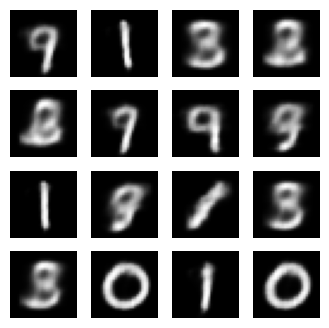

In [22]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

# Display a generated image from the last training epoch

In [23]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 399.5, 399.5, -0.5)

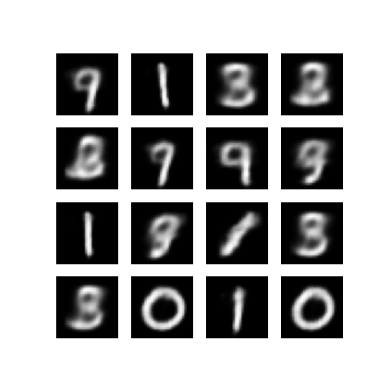

In [24]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

## Display an animated GIF from the save images

In [25]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-25-a6dbd3b71488>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-25-a6dbd3b71488>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



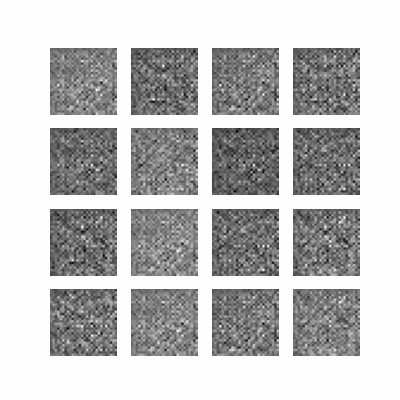

In [26]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

# Display a 2D manifold of digits from the latent space

Running the code below will show a continuous distribution of the different digit classes, with each digit morphing into another across the 2D latent space. Use TensorFlow Probability to generate a standard normal distribution for the latent space.

In [27]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

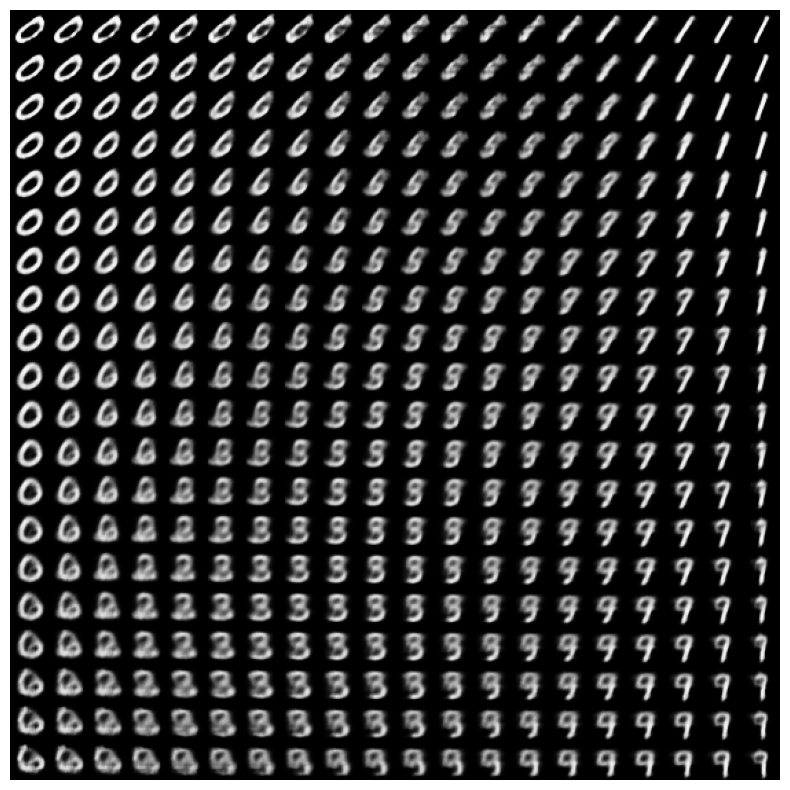

In [28]:
plot_latent_images(model, 20)

# Next steps

Before we move on to the next steps - we need to further analyze the VAE architecture, the training step and the sub sequent steps.

Post that we have to analyze how the various outputs were generated and then we can follow the [next steps](https://www.tensorflow.org/tutorials/generative/cvae#next_steps) as mentioned in the reference article.